* Introduce transfer learning 
* Using a smaller dataset to experiment faster 
* Build a transfer learning feature extraction model using TensorFlow Hub
* Introduce the TensorBoard callback to track model training results
* Compare model results using TensorBoard

In [1]:
import datetime
print(datetime.datetime.now())

2025-07-23 21:22:21.229823


Using a GPU

In [2]:
!nvidia-smi

Wed Jul 23 21:22:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.43                 Driver Version: 566.43         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P3             16W /   40W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data

For many of the problems we will want to use deep learning for, chances are, a working model already exists.

And the good news is, we can access many of them on TensorFlow Hub.

TensorFlow Hub is a repository for existing model components. It makes it so we can import and use a fully trained model with as little as a URL.

Now, I really want to demonstrate the power of transfer learning to you.

To do so, what if I told you we could get much of the same results (or better) than our best model has gotten so far with only 10% of the original data, in other words, 10x less data.

This seems counterintuitive right?

Wouldn't we think more examples of what a picture of food looked like led to better results?

And we would be right if we thought so, generally, more data leads to better results.

However, what if we didn't have more data? What if instead of 750 images per class, we had 75 images per class?

Collecting 675 more images of a certain class could take a long time.

So this is where another major benefit of transfer learning comes in.

Transfer learning often allows you to get great results with less data.



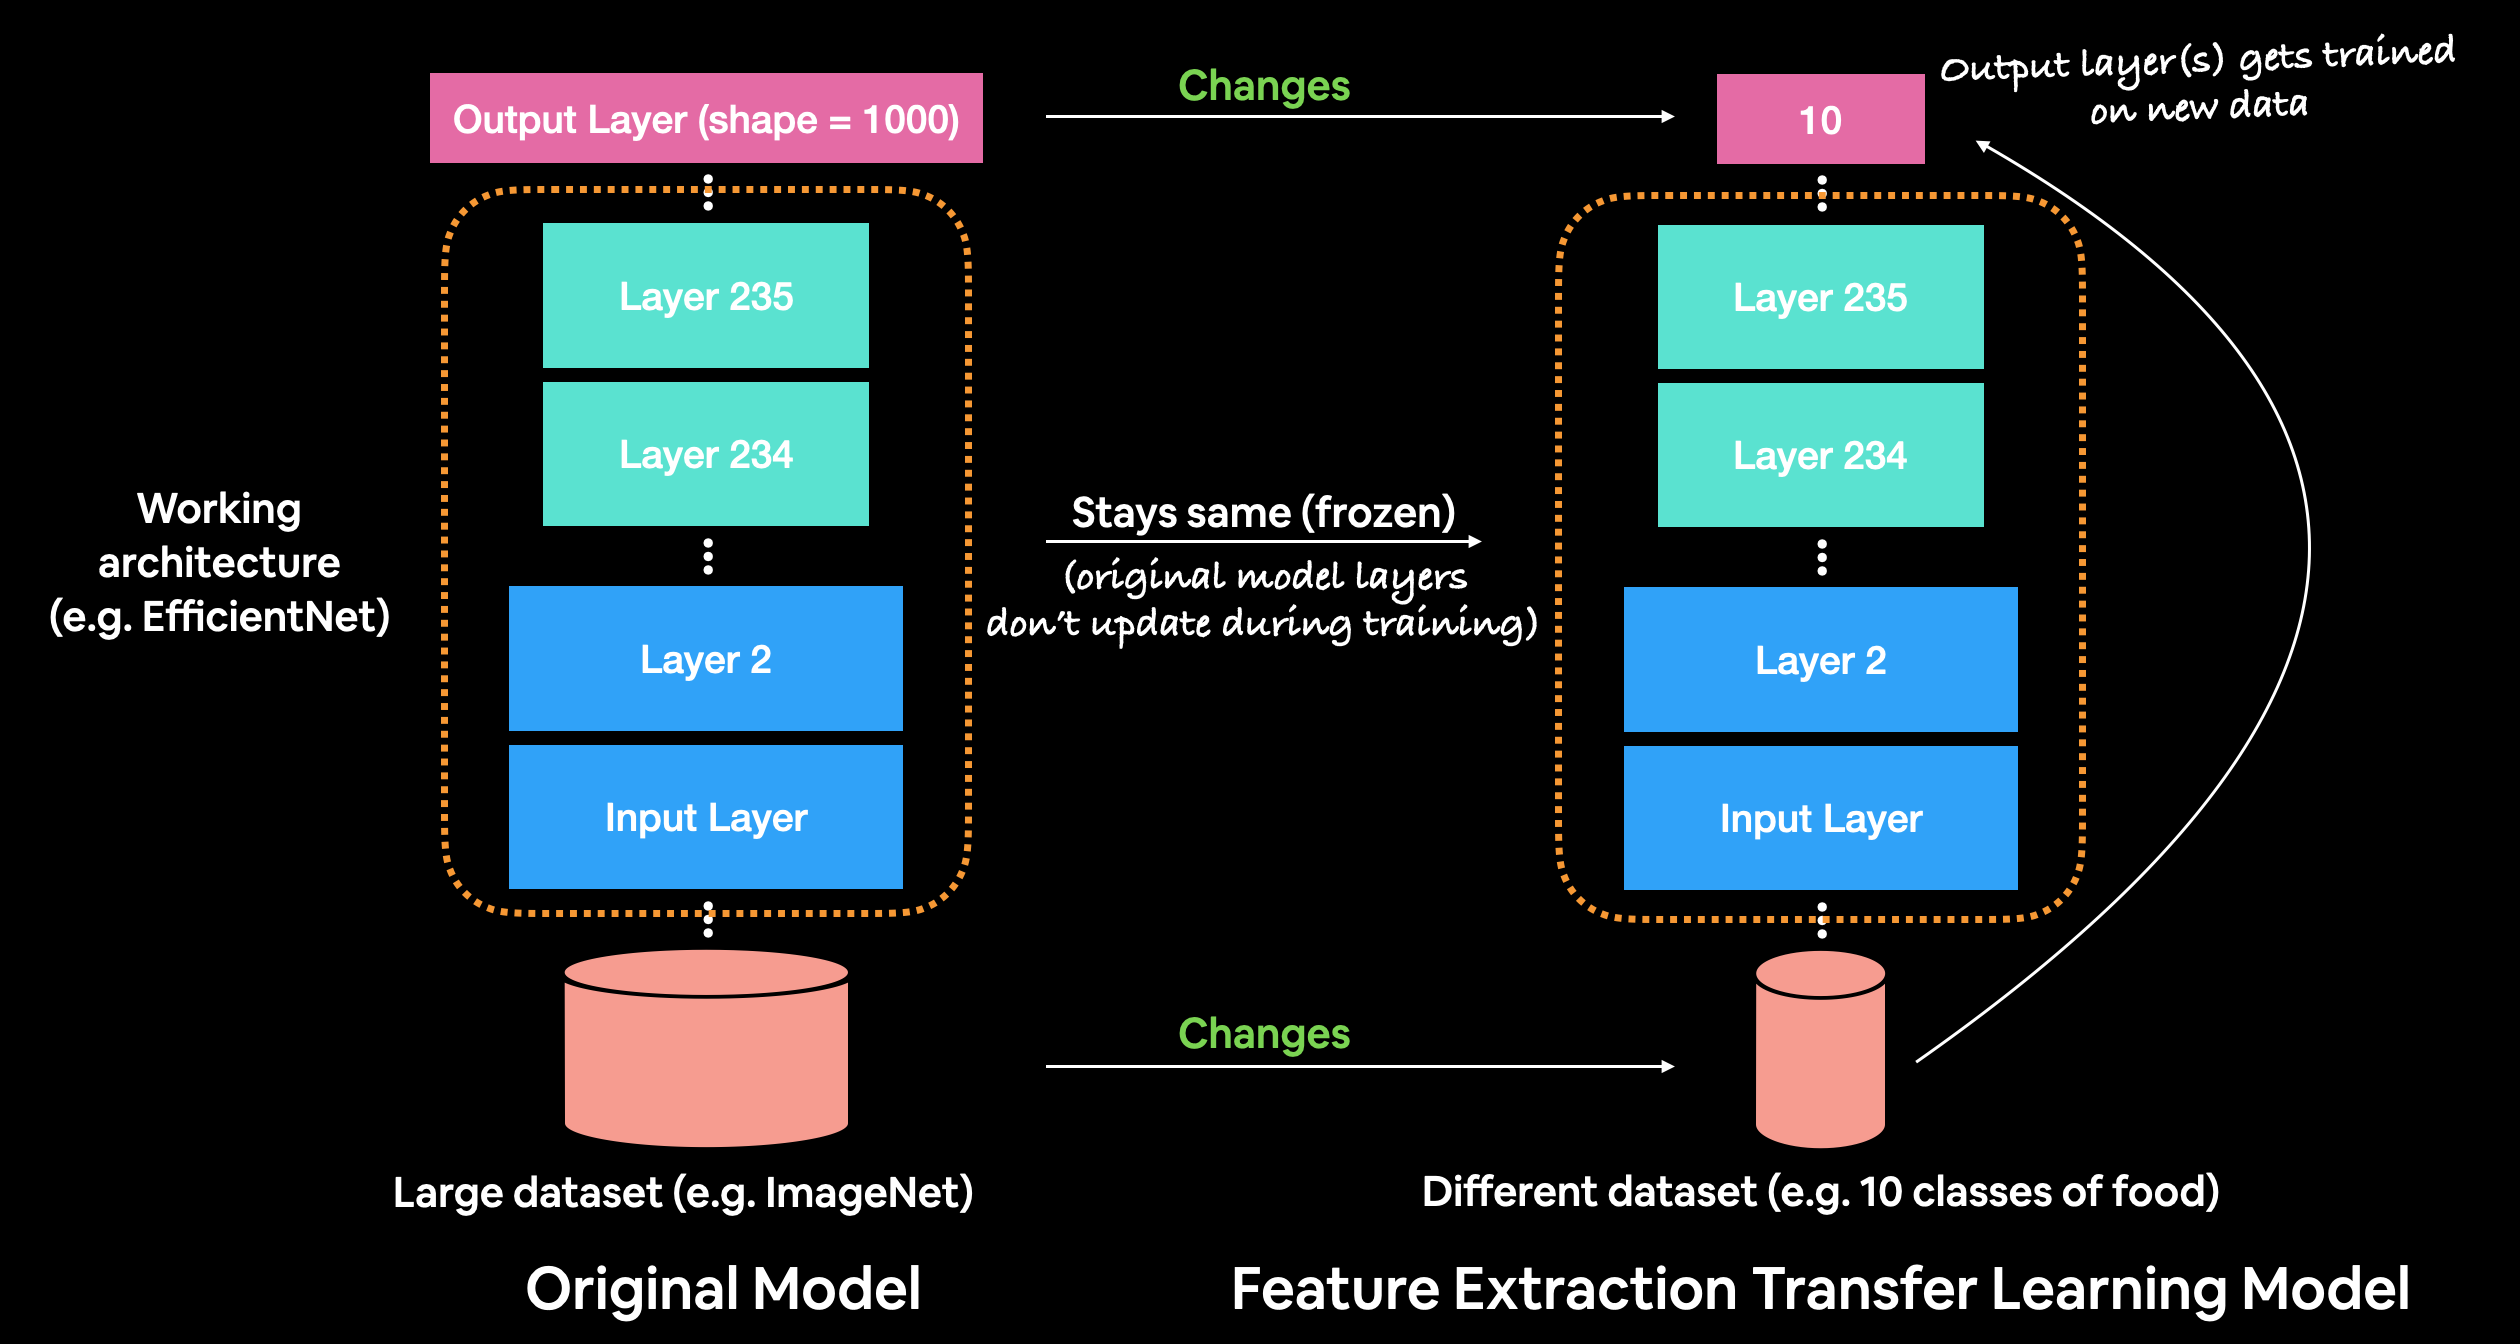

Downloading the data

In [3]:
# import wget
# import zipfile

# # Download the zip file using Python wget
# url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
# wget.download(url, "10_food_classes_all_data.zip")  # this saves the file

# # Unzip the downloaded file
# with zipfile.ZipFile("10_food_classes_all_data.zip", "r") as zip_ref:
#      zip_ref.extractall()


In [4]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_all_data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
    for dirname in dirnames:
        print(f"Directory: {dirname}")
    for filename in filenames:
        print(f"File: {filename}")
    print("\n")  # Add a newline for better readability

There are 2 directories and 0 images in '10_food_classes_all_data'
Directory: test
Directory: train


There are 10 directories and 0 images in '10_food_classes_all_data\test'
Directory: chicken_curry
Directory: chicken_wings
Directory: fried_rice
Directory: grilled_salmon
Directory: hamburger
Directory: ice_cream
Directory: pizza
Directory: ramen
Directory: steak
Directory: sushi


There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'
File: 101833.jpg
File: 10340.jpg
File: 1035626.jpg
File: 1048226.jpg
File: 1075859.jpg
File: 1076489.jpg
File: 108559.jpg
File: 1095245.jpg
File: 1125163.jpg
File: 1134602.jpg
File: 1147753.jpg
File: 115224.jpg
File: 1165404.jpg
File: 118944.jpg
File: 1208906.jpg
File: 1213873.jpg
File: 1215399.jpg
File: 1225331.jpg
File: 1234505.jpg
File: 1236329.jpg
File: 1237705.jpg
File: 1240973.jpg
File: 1248926.jpg
File: 1278457.jpg
File: 1318090.jpg
File: 1333857.jpg
File: 1346888.jpg
File: 1349731.jpg
File: 1351520.jpg
File: 13611

Creating data loaders

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir ="10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

train_datagen=ImageDataGenerator(rescale=1/255.0)
test_datagen=ImageDataGenerator(rescale=1/255.0)

print("Training data:")
train_data_10_percent=train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    batch_size=32,  
    class_mode="categorical",
)

print("Testing data:")

test_data=test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
)

Training data:
Found 7500 images belonging to 10 classes.
Testing data:
Found 2500 images belonging to 10 classes.


Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

Callbacks

Callbacks is an extra functionality , we can add to the model to be performed during or after training.

* Experiment tracking with TensorBoard: log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters).
* Model checkpointing: save your model as it trains so you can stop training if needed and come back to continue off where you left.
* Early stopping:  leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve.


The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard().

Its main functionality is saving a model's training performance metrics to a specified log_dir.

By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).

In [6]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir=dir_name+ "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named [dir_name]/[experiment_name]/[current_timestamp], where:

dir_name is the overall logs directory
experiment_name is the particular experiment
current_timestamp is the time the experiment started based on Python's datetime.datetime().now()

Creating models using TensorFlow Hub

1. ResNetV2 - a state of the art computer vision model architecture from 2016.
2. EfficientNet - a state of the art computer vision architecture from 2019.

* The differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.
For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

2. Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

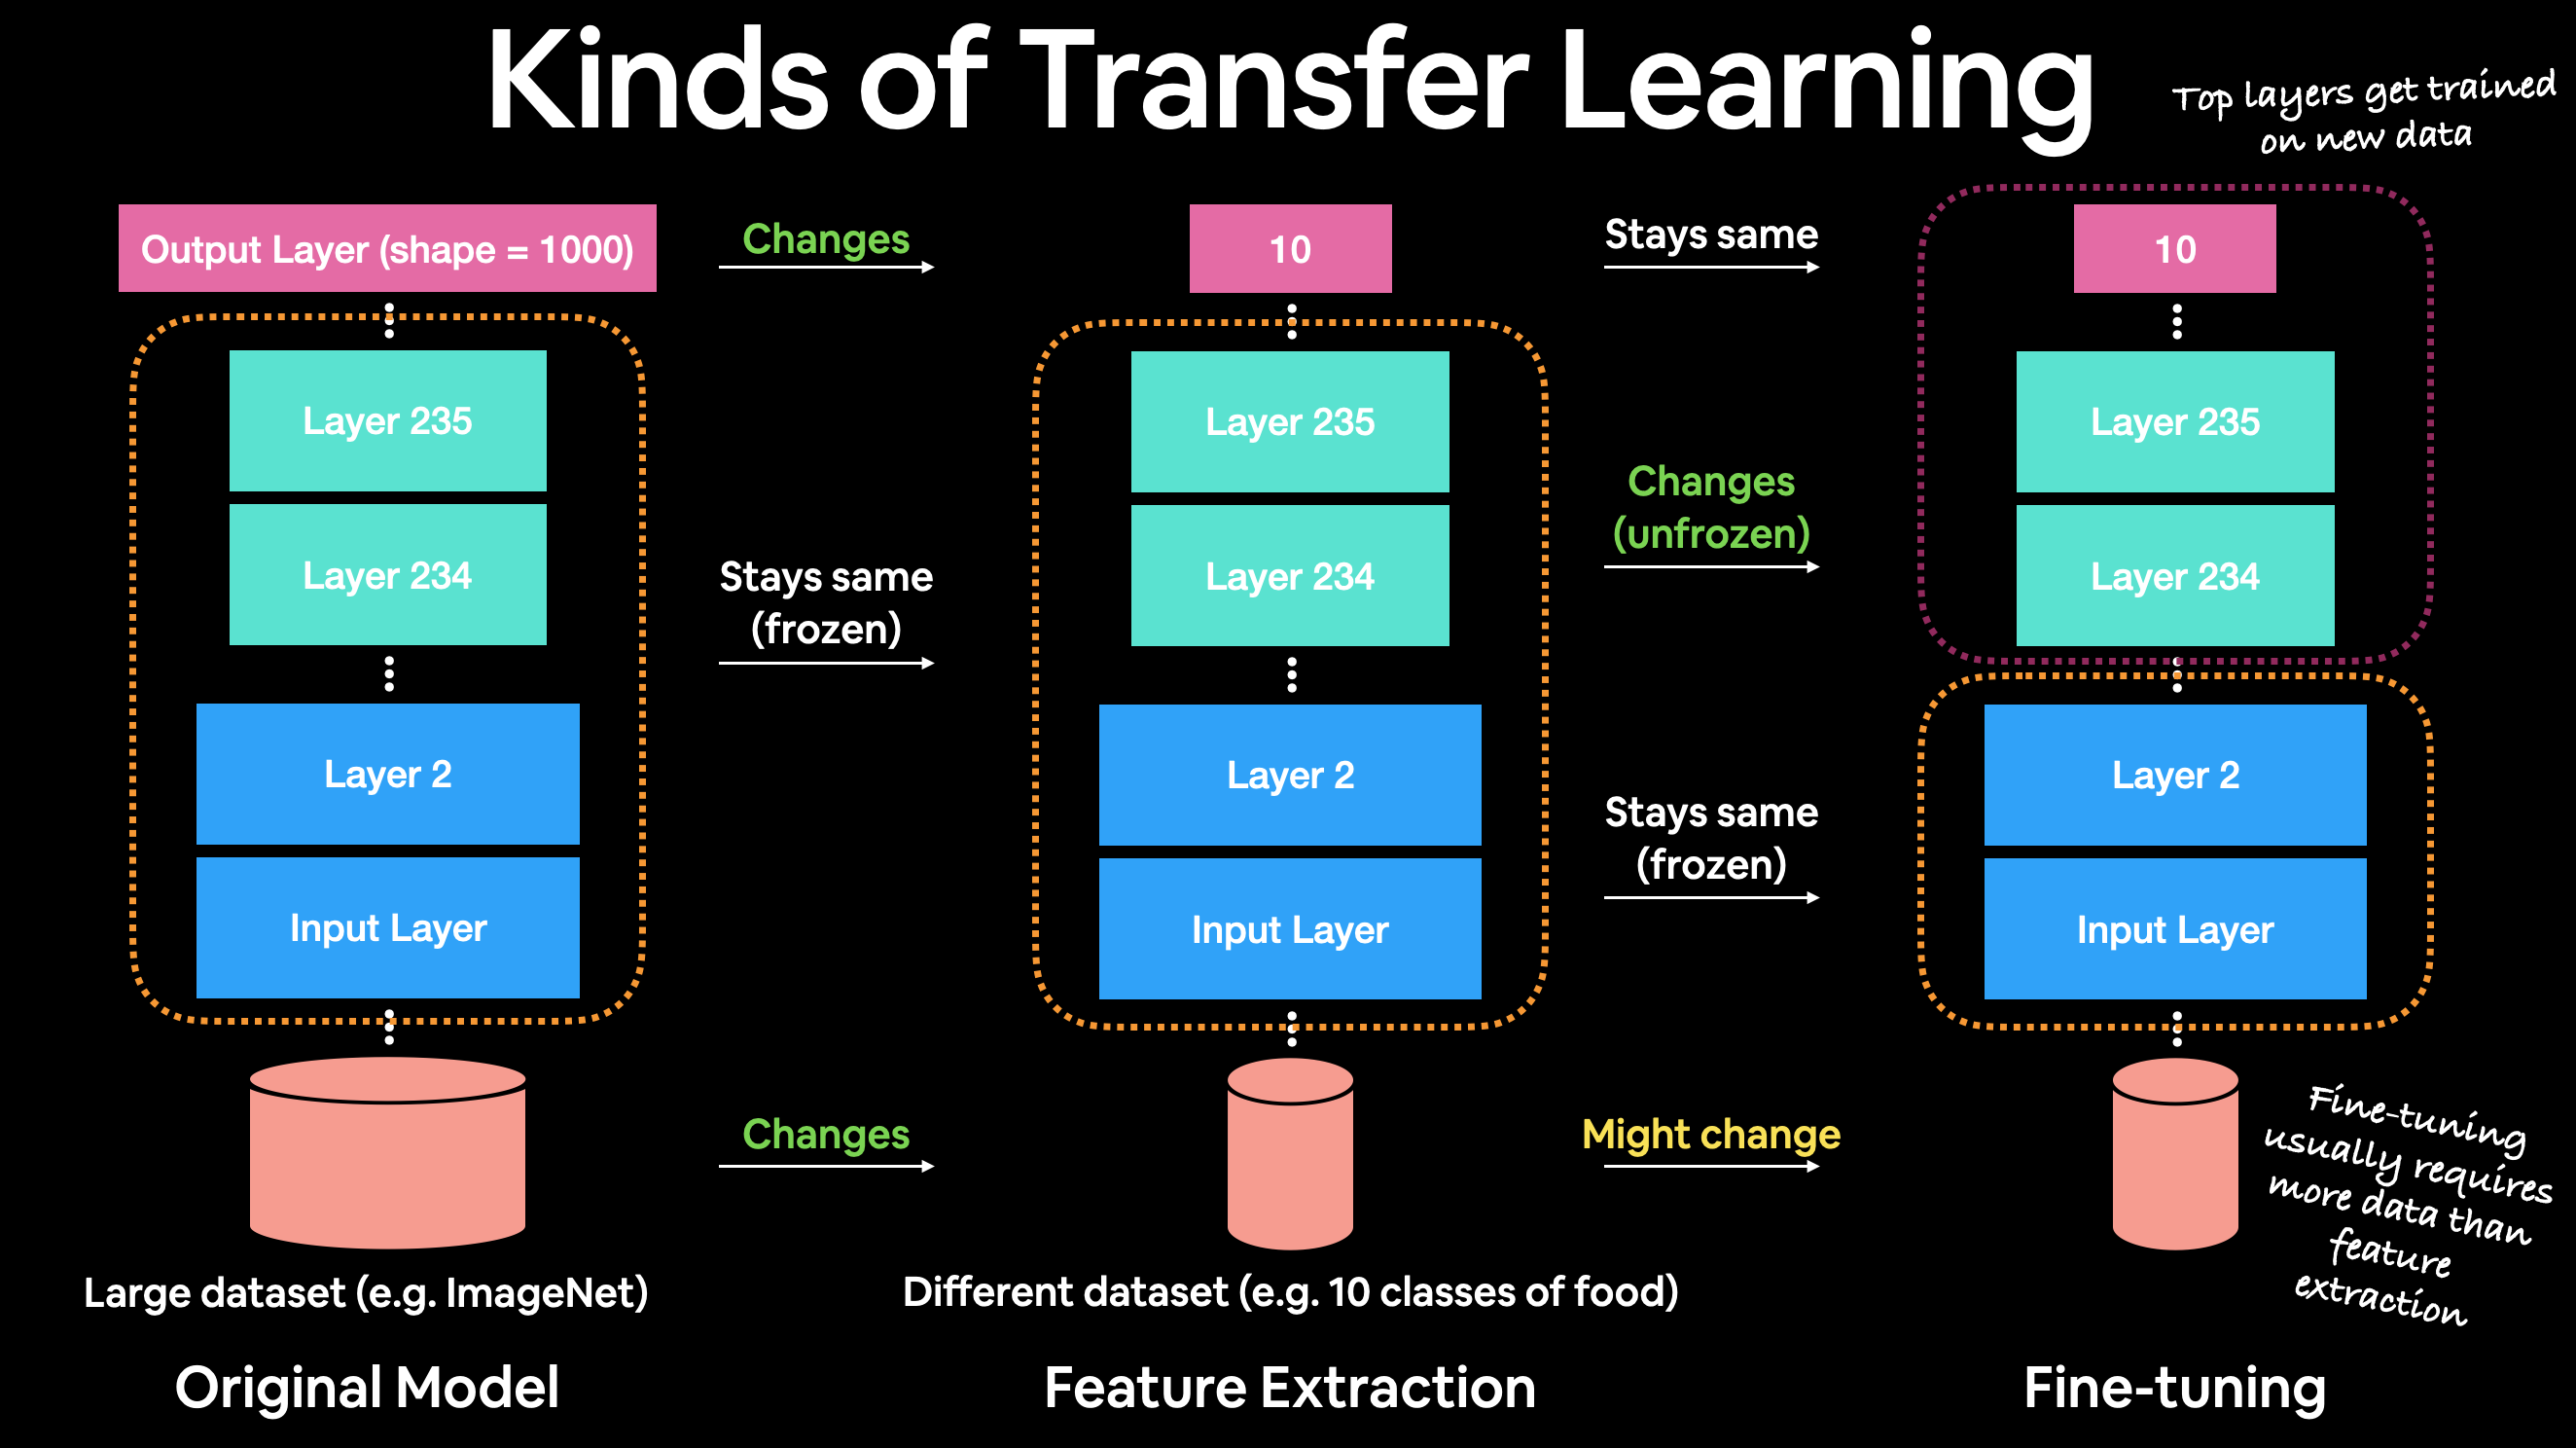

The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
print(tf.__version__)
print(hub.__version__)


2.19.0
0.16.1


In [8]:
# resnet 50 v2 feature vector

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


# EfficientNetB0 feature vector(version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
# pip uninstall keras tf-keras -y

In [10]:
# pip install --upgrade tensorflow tensorflow-hub

In [11]:
# pip install --upgrade tensorflow tensorflow-hub

In [13]:
import tensorflow as tf
import tensorflow_hub as hub

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Use Sequential — this avoids the symbolic evaluation problem
model = tf.keras.Sequential([
    hub.KerasLayer(resnet_url, input_shape=(224, 224, 3), trainable=False),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if using one-hot
    metrics=['accuracy']
)

model.summary()


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x0000020358EE9AB0> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

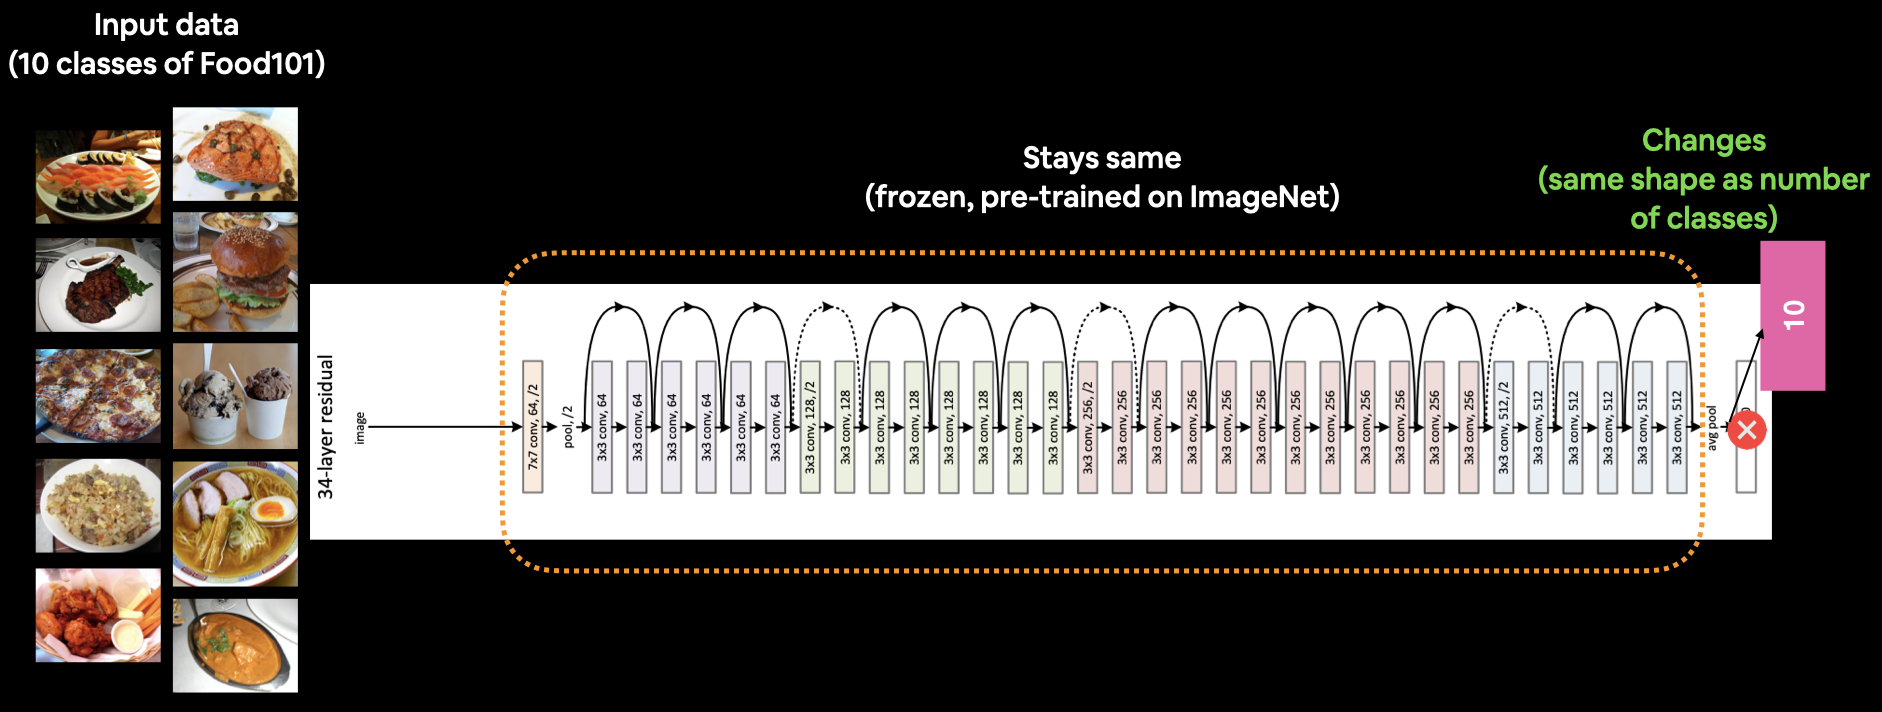

In [ ]:
# pip install --upgrade tensorflow tensorflow-hub

Note: you may need to restart the kernel to use updated packages.
